# Relatório final

## Problema

Alocar o máximo de filmes possíveis para assistir em um dia, dado uma lista de filmes com limitações em horário e categoria
Sendo assim, não é possível alocar um filme em horário em que outro filme já esteja alocado. Além disso, cada filme está classificado
em uma categoria, existindo um limite de filmes que podem ser assistidos de cada categoria.


<p> Um exemplo de entrada que exemplifica uma lista de filmes a serem alocados, é dada por:</p>

<code>
10 4 <br>
1 3 1 2 <br>
11 13 3<br>
14 15 3<br>
10 16 2<br>
10 14 1<br>
11 17 2<br>
11 14 3<br>
13 15 3<br>
14 15 1<br>
12 16 4<br>
12 13 4<br>
</code>

<ul>
    <li>A primeira linha indica o número de filmes envolvidos (10) e a quantidade de categorias (4)</li>
    <li>A segunda linha o número máximo de filmes que podem ser alocados por categoria (só pode ter 1 filme da categoria 0, por exemplo)</li>
    <li>Nas linhas seguintes, cada linha representa um filme. Da esquerda para direita estão: o horário de início do filme, o horário de fim e a categoria na qual se encaixa</li>
</ul>


## Métricas e Variáveis

<p>Para a alocação de um maior número possível de filmes, dados as restrições, serão utilizadas diferentes abordagens a fim de analisar a efetividade de cada uma. No caso será testado
    um algoritmo do tipo guloso, um do tipo aleatório, uma busca exaustiva (e paralela) e programação dinâmica (alocando recursos em GPU).
</p>

<p>Entretanto, para classificar o desempenho de cada abordagem é necessário definir quais métricas serão utilizadas para comparativo. Portanto, serão consideradas:</p>
<ul>
    <li>O número total de filmes alocados</li>
    <li>O tempo total alocado (quantas horas do dia foram ocupadas)</li>
    <li>Tempo de execução de cada heurística</li>
</ul>

<p>Além disso, não é suficiente que se teste os algoritmos para apenas 1 input fixo, pois é necessário avaliar a influência das variáveis no desempenho de cada heurística.
    Portanto, gera-se inputs variando:
</p>

<ul>
    <li>A quantidade total de filmes a alocar em cada input</li>
    <li>O número de categorias possíveis em cada input</li>
</ul>

<p>Para cada variável será gerado um batch de testes em que a variável testada muda por input enquanto as restantes se mantém. A média de duração de cada filme se mantém a mesma 
    para todos os testes neste relatório (2 horas).</p>

Também limitou-se o número máximo de filmes que precisam ser alocados, de forma a ser viável a execução de uma busca exaustiva e sua comparação em relação as outras abordagens

## Pipeline do projeto

<h3>Gerando inputs</h3>
<p>Para gerar os inputs como descrito na sessão anterior, utilizou-se do script <b>input_batch_lite.py</b> localizado no diretótio <b>scripts</b>.
    Esse script gera dois diretórios dentro de <b>inputs</b>. Cada diretório testa uma variável específica do problema.
    Então o diretório de "CATEGORIA" contém inputs com número fixo de filmes (30) entre os arquivos, mas número variável de categorias (1 até 15).
    Já o diretório de "FILMES" contém inputs com número fixo de categorias (7) entre os arquivos, mas número variável de filmes (1 até 40)  </p>
<p>Os comandos para rodar o script estão detalhados no <b>READ.ME</b> da raíz deste projeto</p>

<h3>Executando o algoritmo</h3>
<p>A execução do algoritmo se dá pelo script <b>run_heuristics_lite.py</b> localizado em <b>scripts</b>. Esse script itera sobre as heurísticas presentes 
    no diretório <b>heurisitcas</b> e, para cada heurística, testa os batches de input gerados na sessão anterior. O resultado de cada teste
    é armazenado em um arquivo csv no diretório da heurística (<b>results.csv</b>)
    
<b>A paralelização via GPU foi testada de maneira diferente:</b> há um arquivo .ipynb dentro do diretório <b>paralelismo_gpu</b>. É
possível subir esse notebook no Google Colaboratory para facilitar a execução, uma vez que é necessário a presença de GPU. (não esquecer de subir os inputs
da forma descrita no notebook).
O arquivo de resultado (csv) pode ser importado para o diretório interno deste projeto para fins de análise
</p>

<h3>Analisando desempenho</h3>
<p>A análise de desempenho de cada heurística é realizada por este próprio jupyter notebook. Esse notebook coleta as informações
    presentes nos csv's de resultado e armazena-os em dataframes (pandas). Assim é possível gerar gráficos e realizar medidas mais facilmente dos resultados coletados</p

---

# Métodos e heurísticas

## Gulosa

### Código

<span style="font-size: 13px">

```c++

#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <iostream>
using namespace std;

int main(int argc, char *argv[]){
    //Recebe o nome da variavel testada e o nome do arquivo
    string variavel = argv[1]; 
    string arquivo = argv[2];

    clock_t start, end;
    start = clock();
    
    struct filme{
        int id;
        int inicio;
        int fim;
        int duracao;
        int categoria;
    };

    int n = 0;
    int c = 0;


    vector<filme> filmes;
    vector<int> categorias;
    vector<filme> lista_filmes;

    //n = numero de filmes;  c = numero de categorias
    cin >> n >> c;

    //Vetor de categorias
    int n_filmes_categoria;
    for (int i = 0; i < c; i++){
        cin >> n_filmes_categoria;
        categorias.push_back(n_filmes_categoria);
    }

    filmes.reserve(n); // reserva o espaço na memoria

    //Vetor de filmes
    int inicio, fim, categoria;
    for (int i = 0; i < n; i++){
        cin >> inicio;
        cin >> fim;
        cin >> categoria;
        if (inicio > fim){
            continue;
        }
        if (inicio == fim){
            fim += 1; 
        }
        filmes.push_back({i, inicio, fim, fim - inicio, categoria});
    }

    // Ordena por ordem crescente de hora de fim
    sort(filmes.begin(), filmes.end(), [](auto& i, auto& j){return i.fim < j.fim;}); 
    int i = 0;
    for(auto& el : filmes){
        if(i == 0){
            lista_filmes.push_back(el);
            i += 1;
        }
        //Verifica se horário é válido e se a categoria permite adição a lista
        if(el.inicio >= lista_filmes[i-1].fim && categorias[el.categoria-1] != 0){
            lista_filmes.push_back(el);
            categorias[el.categoria-1] -= 1; 
            i += 1;
        }
    }

    end = clock();
    double time_taken = double(end - start) / double(CLOCKS_PER_SEC);

    int duracao_total = 0;
    for(auto& el:lista_filmes){
        duracao_total += el.duracao;
        std::cout << el.id << " ";
    }
    std::cout << std::endl;
    
    // Escreve novo resultado no csv
    // Métricas: número de filmes alocados, quantidade de horas ocupadas, tempo de execução
    ofstream outputFile;
    string result_file = "../heuristicas/gulosa/results.csv";  // Caminho relativo ao script que chama a heuristica
    outputFile.open(result_file, ios::app);
    string result = variavel + "," + to_string(lista_filmes.size()) + "," + to_string(duracao_total) + 
        "," + to_string(time_taken) + "," + arquivo;
    outputFile << result << endl;
    return 0;
}

### Input

<p>O programa recebe como argumentos de linha de comando:</p>
<ul>
    <li>Nome da variável testada</li>
    <li>Nome do arquivo de input</li>
</ul>
<p>Em seguida, recebe do arquivo de input:</p>
<ul>
    <li><b>n</b>: Número de filmes no arquivo de input</li>
    <li><b>c</b>: Número total de categorias no arquivo de input</li>
</ul>
<p>Além disso, armazena o número máximo de filmes possíveis por categoria em um vetor:<br>
Ex: Para o exemplo de input dado no começo do relatório, o vetor seria [1, 3, 1, 2]

Por fim, itera sobre as linhas do arquivo de input, armazenando os filmes em um vetor</p>

<p>Os filmes são definidos por um struct <b>filme</b> com os campos de:</p>
<ul>
    <li><b>id</b></li>
    <li><b>inicio</b></li>
    <li><b>fim</b></li>
    <li><b>duracao</b></li>
    <li><b>categoria</b></li>

<p>É importante notar que os filmes que terminam após as 23 horas e os que iniciam e terminam na mesma hora, não serão considerados e, portanto, são retirados da lista</p>

### Funcionamento

<p>A heurística consiste constantemente utilizar uma estratégia ótima para contextos locais, esperando encontrar um ótimo em contexto global como resultado.
    No caso o algoritmo sempre irá escolher o filme que tem o horário de encerramento mais cedo.<br>
    Para aplicar a heurística, primeiro ordena-se todos os filmes por horário de encerramento (do mais cedo para o mais tarde).
    Em seguida, itera-se sobre os filmes, aramazenando-os na lista resultado e reduzindo em 1 o valor da categoria correspondente ao filme no vetor
    de categorias. <br>
    Antes de adicionar um filme é necessário verificar:
    <ol>
        <li>Se o filme que irá ser adicionado possui um horário de inicio posterior ao horário de fim do último filme adicionado a lista.</li>
        <li>Se a categoria do filme ainda permite a adição de mais filmes</li>
    </ol>
    Se passar nas duas condições, o filme é adicionado.
</p>

### Output

<p>O número de filmes alocados, o tempo de alocação total no dia e o tempo de execução são armazenados em uma nova entrada no arquivo csv do mesmo diretório (<b>results.csv</b>)</p>

<img src="imgs/output_gulosa.png" alt="escreve output">

### Profiling

<p>O profiling foi realizado com um arquivo de input contendo 10000 filmes e 5 categorias.<br>
No total o programa executou 38,232,014 instruções (considerando a execução de outros arquivos envolvidos nas bibliotecas utilizadas).<br><br>

<img src="imgs/profiling/prof_gulosa0.png" width="1500" height="400">

<br><br>
A leitura e alocação dos filmes do input em vetores são os maiores responsáveis pelo número de intrução: mais de 89% das instruções.
A execução do algoritmo em si foi responsável por apenas 0.68% das instruções totais. A ordenação dos filmes por horário de término, a parte mais custosa da heurística, 
foi responsável por 0.38% das instruções.

<br><br>
<img src="imgs/profiling/prof_gulosa1.png" width="1500" height="600">

<br><br>
<img src="imgs/profiling/prof_gulosa2.png" width="1500" height="600">

</p>

## Aleatória

### Código

<span style="font-size: 13px">

```c++

#include <iostream>
#include <vector>
#include <algorithm>
#include <random>
#include <chrono>
#include <fstream>
using namespace std;

int main(int argc, char *argv[]){
    //Recebe o nome da variavel testada e o nome do arquivo
    string variavel = argv[1]; 
    string arquivo = argv[2];

    clock_t start, end;
    start = clock();

    unsigned seed = std::chrono::system_clock::now().time_since_epoch().count();
    std::default_random_engine generator (seed);
    std::uniform_real_distribution<double> distribution(0.0, 1.0);

    struct filme{
        int id;
        int inicio;
        int fim;
        int duracao;
        int categoria;
    };

    int n = 0;
    int c = 0;

    vector<filme> filmes;
    vector<int> categorias;
    vector<filme> lista_filmes;

    //n = numero de filmes;  c = numero de categorias
    cin >> n >> c;

    int n_filmes_categoria;
    for (int i = 0; i < c; i++){
        cin >> n_filmes_categoria;
        categorias.push_back(n_filmes_categoria);
    }

    filmes.reserve(n); // reserva o espaço na memoria

    int inicio, fim, categoria;
    for (int i = 0; i < n; i++){
        cin >> inicio;
        cin >> fim;
        cin >> categoria;
        if (inicio > fim){
            continue;
        }
        if (inicio == fim){
            fim += 1; 
        }
        filmes.push_back({i, inicio, fim, fim - inicio, categoria});
    }

    // Ordena por ordem crescente de hora de fim (GULOSA)
    sort(filmes.begin(), filmes.end(), [](auto& i, auto& j){return i.fim < j.fim;}); 

    // Vetor de horários
    vector<int> horarios (24, 0);

    int i = 0;
    bool disponivel;
    for(auto& el : filmes){
        disponivel = true;
        // 25% de chance de pegar outro filme (ALEATORIEDADE)
        if(distribution(generator) > 0.75 && i < n){
            std::uniform_int_distribution<int> distributionInt(i, n-1);
            int p  = distributionInt(generator);

            if(categorias[filmes[p].categoria-1] != 0){    // Verificação de categoria disponível
                for(int hora = filmes[p].inicio; hora <= filmes[p].fim; hora++){   // Verificação de horário disponível
                    if (horarios[hora] == 1){
                        disponivel = false;
                        break;
                    }
                }
                if(disponivel){
                    lista_filmes.push_back(filmes[p]);
                    categorias[filmes[p].categoria-1] -= 1; 
                    for(int hora = filmes[p].inicio; hora <= filmes[p].fim; hora++){ 
                        horarios[hora] = 1;
                    }
                    filmes.erase(filmes.begin()+p-1);
                    n = n - 1;
                }
            } 
        }
        else{
            if(categorias[el.categoria-1] != 0){    // Verificação de categoria disponível
                for(int hora = el.inicio; hora <= el.fim; hora++){   // Verificação de horário disponível
                    if (horarios[hora] == 1){
                        disponivel = false;
                        break;
                    }
                }
                if(disponivel){
                    lista_filmes.push_back(el);
                    categorias[el.categoria-1] -= 1; 
                    for(int hora = el.inicio; hora <= el.fim; hora++){ 
                        horarios[hora] = 1;
                    }
                }
            } 
        }
        i += 1;   
    }

    end = clock();
    double time_taken = double(end - start) / double(CLOCKS_PER_SEC);

    int duracao_total = 0;
    for(auto& el:lista_filmes){
        duracao_total += el.duracao;
    }

    // Escreve novo resultado no csv
    // Métricas: número de filmes alocados, quantidade de horas ocupadas, tempo de execução
    ofstream outputFile;
    string result_file = "../heuristicas/gulosa_aleatoria/results.csv";  // Caminho relativo ao script que chama a heuristica
    outputFile.open(result_file, ios::app);
    string result = variavel + "," + to_string(lista_filmes.size()) + "," + to_string(duracao_total) + 
        "," + to_string(time_taken) + "," + arquivo;
    outputFile << result << endl;

    return 0;
}

### Input

Funciona da mesma maneira descrita para a heurística gulosa.

### Funcionamento

<p>Diferente da heurística gulosa, a aleatória tem um caráter mais abrangente (<b>exploration</b>) em relação as soluções encontradas.
No caso o algoritmo utiliza-se da aleatorização para causar imprevisibilidade e definir caminhos para soluções que não seriam encontradas pela heurística anterior.<br>
Para esse algoritmo será implementada uma aleatorização em função da heurística anterior, ou seja, o vetor de filmes será ordenado com base no horário de término de cada filme,
e o vetor será iterado nessa ordem.
Porém, o algoritmo define que exista uma chance de 25% de não escolher o próximo filme do vetor para verificação de inclusão. Assim, será escolhido um filme aleatório no vetor
para verificação.<br>

Antes de adicionar um filme é necessário verificar:
<ol>
    <li>Se o filme que irá ser adicionado não conflita com o horário de nenhum outro filme já incluso no resultado</li>
    <li>Se a categoria do filme ainda permite a adição de mais filmes</li>
</ol>
Para a primeira verificação é necessário criar um vetor de horários que mapeia se o horário está disponível ou não (bitmap -> vetor de 0 e 1). Quando um filme for alocado,
os horários correspondentes no bitmap mudarão de 0 para 1.<br>
Se passar nas duas condições, o filme é adicionado.
</p>

### Output

<p>O número de filmes alocados, o tempo de alocação total no dia e o tempo de execução são armazenados em uma nova entrada no arquivo csv do mesmo diretório (<b>results.csv</b>)</p>

<img src="imgs/output_gulosa.png" alt="escreve output">

### Profiling

<p>O profiling foi realizado com um arquivo de input contendo 10000 filmes e 5 categorias.<br>
No total o programa executou 39,556,303 instruções (considerando a execução de outros arquivos envolvidos nas bibliotecas utilizadas).<br><br>

<img src="imgs/profiling/prof_aleat0.png"> <br><br>

A leitura e alocação dos filmes do input em vetores são os maiores responsáveis pelo número de intrução: mais de 86% das instruções.<br><br>

<img src="imgs/profiling/prof_aleat1.png"><br><br>
<img src="imgs/profiling/prof_aleat2.png"><br><br>

A execução do algoritmo em si foi responsável por apenas 0.8% das instruções totais. Destaca-se a ordenação proveniente da heurística gulosa no programa, que é responsável
por 0.38% das instruções totais (similar ao profiling da heurística gulosa).<br>

<img src="imgs/profiling/prof_aleat3.png"><br><br>
<img src="imgs/profiling/prof_aleat4.png"><br><br>
<img src="imgs/profiling/prof_aleat5.png"><br>

</p>

## Exaustiva

### Código

<span style="font-size: 13px">

```c++
#include <iostream>
#include <vector>
#include <algorithm>
#include <omp.h>
#include <iostream>
#include <fstream>
using namespace std;

struct filme{
        int id;
        int inicio;
        int fim;
        int duracao;
        int categoria;
};

int maior_valor(vector<filme> filmes, vector<filme>& assistidos, vector<filme>& melhor, vector<int> categorias, vector<int> horarios){
    vector<filme> filmes2 = filmes; 
    vector<int> horarios2 = horarios;
    vector<filme> assistidos2 = assistidos;
    vector<int> categorias2 = categorias;
    int adiciona = 0;
    int com_item = 0;
    bool disponivel = true;


    if(filmes.empty() || horarios.back() == 0){
        return 0;
    }

    if(categorias[filmes[0].categoria-1] != 0){    // Verificação de categoria disponível
        for(int hora = filmes[0].inicio; hora <= filmes[0].fim; hora++){   // Verificação de horário disponível
            if (horarios[hora] == 1 && hora != filmes[0].fim){
                disponivel = false;
                break;
            }
        }
        if(disponivel){
            categorias[filmes[0].categoria-1] -= 1; 
            for(int hora = filmes[0].inicio; hora < filmes[0].fim; hora++){ 
                horarios[hora] = 1;
                horarios.back() -= 1;
            }
            assistidos.push_back(filmes[0]);
            filmes.erase(filmes.begin());
            com_item = maior_valor(filmes, assistidos, melhor, categorias, horarios);  
            adiciona += 1;
        }
    } 
    filmes2.erase(filmes2.begin());

    int sem_item = maior_valor(filmes2, assistidos2, melhor, categorias2, horarios2);

    int valor_atual = assistidos.size();
    int valor_melhor = melhor.size();
    if(valor_atual > valor_melhor){
        melhor = assistidos;
    }
    assistidos.clear();
    return max(sem_item, adiciona+com_item);
}

int main(int argc, char *argv[]){
    float time = omp_get_wtime();

    // Recebe o nome da variavel testada e o nome do arquivo
    string variavel = argv[1]; 
    string arquivo = argv[2];

    int n = 0;
    int c = 0;

    // Vetor de horários
    vector<int> horarios (24, 0);
    horarios.push_back(24);  //Última posição do vetor como soma da quantidade de zeros (horas disponíveis)
    vector<filme> assistidos;
    vector<filme> filmes;
    vector<int> categorias;
    vector<filme> melhor;   //Resposta

    //n = numero de filmes;  c = numero de categorias
    cin >> n >> c;

    //Vetor de categorias
    int n_filmes_categoria;
    for (int i = 0; i < c; i++){
        cin >> n_filmes_categoria;
        categorias.push_back(n_filmes_categoria);
    }

    filmes.reserve(n); // reserva o espaço na memoria

    //Vetor de filmes
    int inicio, fim, categoria;
    for (int i = 0; i < n; i++){
        cin >> inicio;
        cin >> fim;
        cin >> categoria;
        if (inicio > fim){
            continue;
        }
        if (inicio == fim){
            fim += 1; 
        }
        filmes.push_back({i, inicio, fim, fim - inicio, categoria});
    }

    maior_valor(filmes, assistidos, melhor, categorias, horarios);

    time = omp_get_wtime()-time;
    

    int duracao_total = 0;
    for(auto& el:melhor){
        duracao_total += el.duracao;
    }

    // Escreve novo resultado no csv
    // Métricas: número de filmes alocados, quantidade de horas ocupadas, tempo de execução
    ofstream outputFile;
    string result_file = "../heuristicas/exaustiva/results.csv";  // Caminho relativo ao script que chama a heuristica
    outputFile.open(result_file, ios::app);
    string result = variavel + "," + to_string(melhor.size()) + "," + to_string(duracao_total) + 
        "," + to_string(time) + "," + arquivo;
    outputFile << result << endl;

    return 0;
}


Tratamento igual ao das abordagens anteriores

### Funcionamento

A busca exaustiva é um método de força bruta, onde se testam todas as combinações possíveis do problema para identificar a solução ótima.

A implementação segue uma abordagem recursiva, em que a função **maior_valor()** é chamada dentro de si mesma. No caso, a função verifica se é possível alocar o primeiro
filme da lista dentro das restrições dadas no momento. Em caso positivo, a função chama a si mesmo, criando um novo estado em que o filme foi alocado:

```c++
if(categorias[filmes[0].categoria-1] != 0){    // Verificação de categoria disponível
        for(int hora = filmes[0].inicio; hora <= filmes[0].fim; hora++){   // Verificação de horário disponível
            if (horarios[hora] == 1 && hora != filmes[0].fim){
                disponivel = false;
                break;
            }
        }
        if(disponivel){
            categorias[filmes[0].categoria-1] -= 1; 
            for(int hora = filmes[0].inicio; hora < filmes[0].fim; hora++){ 
                horarios[hora] = 1;
                horarios.back() -= 1;
            }
            assistidos.push_back(filmes[0]);
            filmes.erase(filmes.begin());
            com_item = maior_valor(filmes, assistidos, melhor, categorias, horarios);  
            adiciona += 1;
        }
    } 

Em seguida a função chama a si mesmo novamente para gerar um estado em que o filme não foi alocado:

```c++
int sem_item = maior_valor(filmes2, assistidos2, melhor, categorias2, horarios2);

Dessa forma é possível expandir a árvore de busca completamente, encontrando todas as possibilidades de alocação e, sempre retornando o melhor resultado em cada etapa:
```c++
int valor_atual = assistidos.size();
int valor_melhor = melhor.size();
if(valor_atual > valor_melhor){
    melhor = assistidos;
}
assistidos.clear();
return max(sem_item, adiciona+com_item);

**PROBLEMA:** Apesar de sempre encontrar o resultado ótimo, executar a busca exaustiva para entradas grandes não é viável, uma vez que a complexidade do problema cresce exponencialmente
com entradas maiores. Dessa forma, limitou-se os testes para até 40 filmes para fins de comparação

### Output

<p>O número de filmes alocados, o tempo de alocação total no dia e o tempo de execução são armazenados em uma nova entrada no arquivo csv do mesmo diretório (<b>results.csv</b>)</p>

## Exaustiva paralelizada

### Código

<span style="font-size: 13px">


```c++
#include <iostream>
#include <vector>
#include <algorithm>
#include <omp.h>
#include <iostream>
#include <fstream>
using namespace std;

struct filme{
        int id;
        int inicio;
        int fim;
        int duracao;
        int categoria;
};

int maior_valor(vector<filme> filmes, vector<filme>& assistidos, vector<filme>& melhor, vector<int> categorias, vector<int> horarios, int index){
    vector<filme> filmes2 = filmes; 
    vector<int> horarios2 = horarios;
    vector<filme> assistidos2 = assistidos;
    vector<int> categorias2 = categorias;
    int adiciona = 0;
    int com_item = 0;
    bool disponivel = true;


    if(filmes.empty() || horarios.back() == 0 || index < 0){
        return 0;
    }

    if(categorias[filmes[index].categoria-1] != 0){    // Verificação de categoria disponível
        for(int hora = filmes[index].inicio; hora <= filmes[index].fim; hora++){   // Verificação de horário disponível
            if (horarios[hora] == 1 && hora != filmes[index].fim){
                disponivel = false;
                break;
            }
        }
        if(disponivel){
            categorias[filmes[index].categoria-1] -= 1; 
            for(int hora = filmes[index].inicio; hora < filmes[index].fim; hora++){ 
                horarios[hora] = 1;
                horarios.back() -= 1;
            }
            assistidos.push_back(filmes[index]);
            filmes.erase(filmes.begin());
            com_item = maior_valor(filmes, assistidos, melhor, categorias, horarios, index-1);  
            adiciona += 1;
        }
    } 
    filmes2.erase(filmes2.begin());

    int sem_item = maior_valor(filmes2, assistidos2, melhor, categorias2, horarios2, index-1);

    int valor_atual = assistidos.size();
    int valor_melhor = melhor.size();
    if(valor_atual > valor_melhor){
        melhor = assistidos;
    }
    assistidos.clear();
    return max(sem_item, adiciona+com_item);
}


int main(int argc, char *argv[]){
    float time = omp_get_wtime();

    //Recebe o nome da variavel testada e o nome do arquivo
    string variavel = argv[1]; 
    string arquivo = argv[2];

    int n = 0;
    int c = 0;

    // Vetor de horários
    vector<int> horarios (24, 0);
    horarios.push_back(24);  //Última posição do vetor como soma da quantidade de zeros (horas disponíveis)
    vector<filme> assistidos;
    vector<filme> filmes;
    vector<int> categorias;
    vector<filme> melhor;   //Resposta

    //n = numero de filmes;  c = numero de categorias
    cin >> n >> c;

    //Vetor de categorias
    int n_filmes_categoria;
    for (int i = 0; i < c; i++){
        cin >> n_filmes_categoria;
        categorias.push_back(n_filmes_categoria);
    }

    // filmes.reserve(n); // reserva o espaço na memoria

    //Vetor de filmes
    int inicio, fim, categoria;
    for (int i = 0; i < n; i++){
        cin >> inicio;
        cin >> fim;
        cin >> categoria;
        if (inicio > fim){
            continue;
        }
        if (inicio == fim){
            fim += 1; 
        }
        filmes.push_back({i, inicio, fim, fim - inicio, categoria});
    }

    int n_filmes = filmes.size();
    int max_val = 0;
    omp_set_num_threads(8);

    #pragma omp parallel
    {     
        int id, i, nthreads, istart, iend;
        id = omp_get_thread_num();
        nthreads = omp_get_num_threads();
        istart = id*n_filmes /nthreads;
        iend =(id+1) * n_filmes/nthreads;
        if (id == nthreads - 1) iend = n_filmes;
        for (i = istart; i < iend; i++){
            #pragma omp task shared(max_val)
            {
                int value = maior_valor(filmes, assistidos, melhor, categorias, horarios, i);
                #pragma omp critical
                {
                    max_val = std::max(max_val, value);
                }
            }
        }
    }
    

    time = omp_get_wtime()-time;

    int duracao_total = 0;
    for(auto& el:melhor){
        duracao_total += el.duracao;
    }

    // Escreve novo resultado no csv
    // Métricas: número de filmes alocados, quantidade de horas ocupadas, tempo de execução
    ofstream outputFile;
    string result_file = "../heuristicas/exaustiva_paralela/results.csv";  // Caminho relativo ao script que chama a heuristica
    outputFile.open(result_file, ios::app);
    string result = variavel + "," + to_string(melhor.size()) + "," + to_string(duracao_total) + 
        "," + to_string(time) + "," + arquivo;
    outputFile << result << endl;
    return 0;
}


### Funcionamento

A abordagem envolve a mesma estratégia da busca exaustiva mas utiliza-se da biblioteca **OpenMP** para paralelizar o código e distribui-lo em threads

In [107]:
import pandas as pd
import os 
import re
import matplotlib.pyplot as plt
import numpy as np

## Lendo arquivos de resultados

Coluna "variavel":
- categoria
- filme
- media

In [108]:
df_dict = {}
heuristicas = "../heuristicas"
for heuristica in os.listdir(heuristicas):
    f = os.path.join(heuristicas, heuristica)
    df_dict[heuristica] = pd.read_csv(f+"/results.csv")

In [109]:
def extract_value(file_name):
    return int((re.findall('\d+', file_name ))[0])

In [110]:
for df in df_dict.values():
    df["variavel_numero"] = df.apply(lambda x: extract_value(x["nome_arquivo"]), axis = 1)

## Análise de variáveis

In [111]:
def df_filter(df, variable):
    return df[df["variavel"] == variable]

### Número total de filmes

O número de categoria se mantém fixo (5 categorias) e o tempo médio de cada filme também (2 horas)

In [112]:
df_movie_variable_dict = {}
for k, v in df_dict.items():
    df_movie_variable_dict[k] = df_filter(v, "filme")
    df_movie_variable_dict[k] = df_movie_variable_dict[k].drop(["nome_arquivo"], axis = 1)


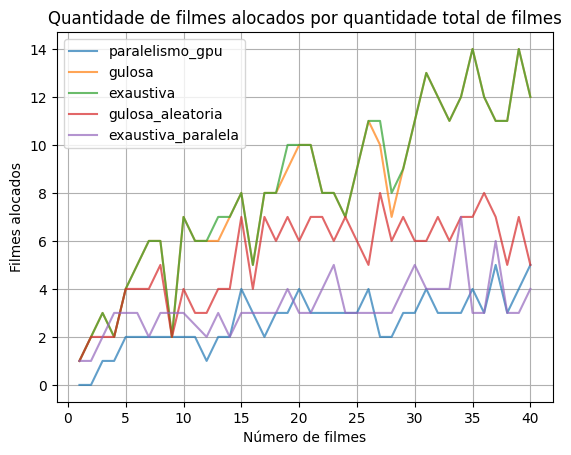

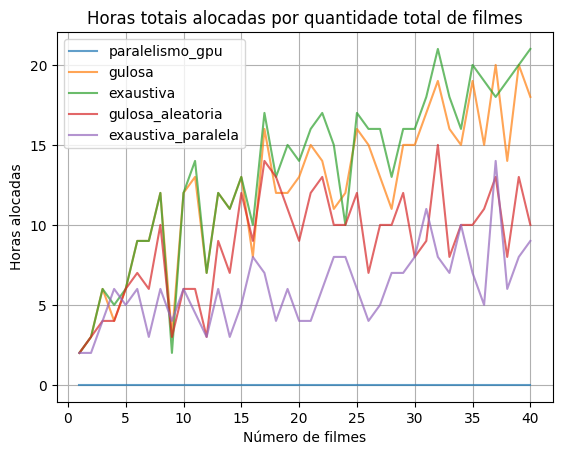

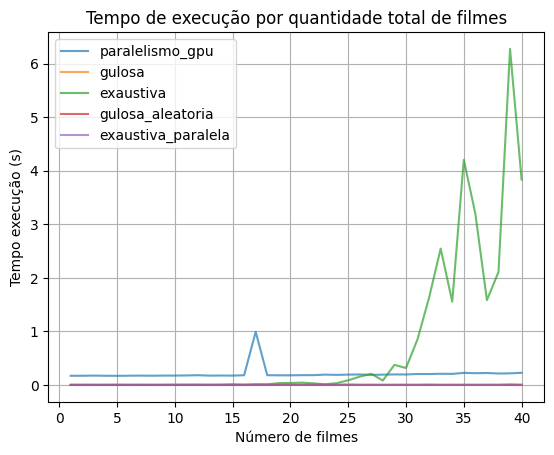

In [113]:
columns = ["numero_filmes", "alocacao_tempo", "tempo_execucao"]
settings = {"numero_filmes": ["Quantidade de filmes alocados", "Filmes alocados"],
         "alocacao_tempo": ["Horas totais alocadas", "Horas alocadas"],
         "tempo_execucao": ["Tempo de execução", "Tempo execução (s)"]}

for column in columns:
    for k, v in df_movie_variable_dict.items():
        xs, ys = zip(*sorted(zip(v["variavel_numero"], v[column])))
        plt.title("{} por quantidade total de filmes".format(settings[column][0]))
        plt.ylabel(settings[column][1])
        plt.xlabel("Número de filmes")
        plt.plot(xs, ys, label = k, alpha = 0.7)
    plt.legend()
    plt.grid(True)
    plt.show()

## Número total de categorias

In [114]:
df_category_variable_dict = {}
for k, v in df_dict.items():
    df_category_variable_dict[k] = df_filter(v, "categoria")
    df_category_variable_dict[k] = df_category_variable_dict[k].drop(["nome_arquivo"], axis = 1)

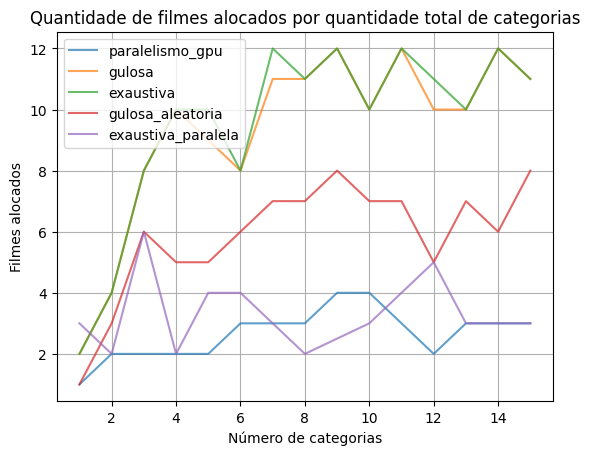

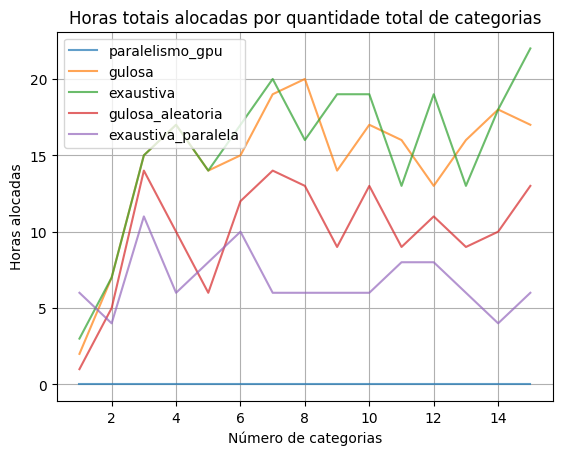

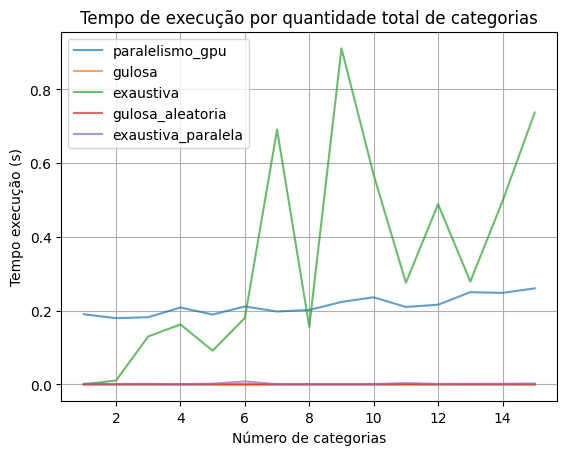

In [115]:
columns = ["numero_filmes", "alocacao_tempo", "tempo_execucao"]
settings = {"numero_filmes": ["Quantidade de filmes alocados", "Filmes alocados"],
         "alocacao_tempo": ["Horas totais alocadas", "Horas alocadas"],
         "tempo_execucao": ["Tempo de execução", "Tempo execução (s)"]}

for column in columns:
    for k, v in df_category_variable_dict.items():
        xs, ys = zip(*sorted(zip(v["variavel_numero"], v[column])))
        plt.title("{} por quantidade total de categorias".format(settings[column][0]))
        plt.ylabel(settings[column][1])
        plt.xlabel("Número de categorias")
        plt.plot(xs, ys, label = k, alpha = 0.7)
    plt.legend()
    plt.grid(True)
    plt.show()